# 预测下月销售量
****
**输入：ID：对于一个tuple(商店ID + 商品ID)**  
**输出： 销售量([ 0, 20 ])**  
**评价指标：RMSE**

In [1]:
from itertools import  product
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

##  数据总览

In [2]:
sales_train = pd.read_csv('sales_train_v2.csv')           # 交易日期、日期所属时间段编号、商店编号、商品编号、单价、销售量
shops = pd.read_csv('shops.csv')                          # 商店名称、编号
item_categories = pd.read_csv('item_categories.csv')      # 类别名称、编号
items = pd.read_csv('items.csv')                          # 商品名称、编号、所属类别编号
test = pd.read_csv('test.csv')                            # ID：tuple(商店ID， 商品ID)
sample_submission = pd.read_csv('sample_submission.csv')  # ID、销售量、销售额

In [3]:
print('shops.info()')
shops.info()
print('-' * 40)
print('items.info()')
items.info()
print('-' * 40)
print('item_categories.info()')
item_categories.info()
print('-' * 40)
print('sales_train.info()')
sales_train.info()
print('-' * 40)
print('test.info()')
test.info()

shops.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
----------------------------------------
items.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
----------------------------------------
item_categories.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
----------------------------------------
sales_train.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 29358

**发现**：共60家店铺，22170种商品，商品分为84类；样本无缺失值。

In [4]:
'''
gg：每个月份每家商品的总销售量表

'''
gg = sales_train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':["sum"]}).reset_index()
gg.columns = ['date_block_num', 'shop_id', 'sum_item_cnt_day']

'''
每家店铺有交易记录的月份数

'''
for i in range(60):
    print(gg[gg['shop_id'] == i]['date_block_num'].value_counts().size, end = '  ')

2  2  34  34  34  33  34  34  4  4  33  1  34  20  34  34  34  20  34  34  2  34  34  4  34  34  34  32  34  29  26  34  7  9  16  34  1  34  34  20  11  34  34  25  34  34  34  34  19  23  34  33  34  34  28  30  34  32  32  34  

**发现**：有些店铺只有某几个月存在交易记录。

In [5]:
size_shop = test.groupby("shop_id").size()

**发现**：测试集中果然删去了这类不具参考价值的店铺, 删去了18家，剩下共42家店铺。

In [6]:
size_item = test.groupby("item_id").size()

In [7]:
'''
验证是否每家均出售了相同的5100种商品，如果是，则输出YES。（实际上只验证了首尾两家）
'''
tt = test.sort_values(['shop_id'])
tp = tt.tail(5100).sort_values(['item_id'])['item_id'].values  == tt.head(5100).sort_values(['item_id'])['item_id'].values
for i in tp:
    if i == False:
        print('NO')
        break
print("YES")

YES


**发现**：测试集中共有5100种商品，每件商品均有42家店铺卖出，即测试集中的每家店均卖出了这5100种商品。

'''
按季度分块
'''
sales_train['date_block_Quarter'] = 0
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 0) & (sales_train['date_block_num']< 3)] = 0
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 3) & (sales_train['date_block_num']< 6)] = 1
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 6) & (sales_train['date_block_num']< 9)] = 2
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 9) & (sales_train['date_block_num']< 12)] = 3
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 12) & (sales_train['date_block_num']< 15)] = 4
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 15) & (sales_train['date_block_num']< 18)] = 5
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 18) & (sales_train['date_block_num']< 21)] = 6
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 21) & (sales_train['date_block_num']< 24)] = 7
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 24) & (sales_train['date_block_num']< 27)] = 8
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 27) & (sales_train['date_block_num']< 30)] = 9
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 30) & (sales_train['date_block_num']< 33)] = 10
sales_train['date_block_Quarter'][(sales_train['date_block_num'] >= 33) & (sales_train['date_block_num']< 36)] = 11
'''
按季度网格化，得到该月的本季度所有商店的所有商品当月的销售量
'''
matrix=[]
cols=['date_block_num','shop_id','item_id']
for i in range(11):
    sales = sales_train[sales_train['date_block_Quarter'] == i]
    for j in range(i*3, (i + 1)*3):
        matrix.append(np.array(list(product([i],sales.shop_id.unique(),sales.item_id.unique())),dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

sales_train1 = pd.merge(matrix,sales_train, on =cols ,how ='left')
sales_train1.drop(['date', 'date_block_Quarter'], axis=1, inplace=True)

## 数据整合
**将各个表的信息整合到一张表上，并对测试集和训练集做相同处理，并将测试集和训练集联合为一张表，为特征工程做准备**

In [8]:
'''
统计不同ID的各月销售量，将同一个月同一家商店的同一个商品的销售记录合并，按月为最小时间单位
'''
cols = ['shop_id', 'item_id', 'date_block_num']
temp = sales_train[['shop_id','item_id', 'date_block_num', 'item_cnt_day']]
train = temp.groupby(by=cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum':'item_cnt_month'})
train['item_cnt_month'] = train['item_cnt_month'].astype(int).fillna(0)

In [9]:
'''
改变商品类别名分类
'''
item_categories['item_category_name'][0] = 0
item_categories['item_category_name'][1:8] = 1
item_categories['item_category_name'][8] = 2
item_categories['item_category_name'][9] = 3
item_categories['item_category_name'][10:18] = 4
item_categories['item_category_name'][18:32] = 5
item_categories['item_category_name'][32:37] = 6
item_categories['item_category_name'][37:42] = 7
item_categories['item_category_name'][42:55] = 8
item_categories['item_category_name'][55:61] = 9
item_categories['item_category_name'][61:73] = 10
item_categories['item_category_name'][73:79] = 11
item_categories['item_category_name'][79:81] = 12
item_categories['item_category_name'][81:83] = 13
item_categories['item_category_name'][83] = 14
item_categories = item_categories.rename(columns={'item_category_name':'new_category_id'})

In [10]:
'''
加入各商品的类别特征
'''
train = pd.merge(train, items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
train = pd.merge(train, item_categories, on = ['item_category_id'], how = 'left')
train.drop(['item_category_id'], axis=1, inplace=True)

In [11]:
'''
选出商店所在城市
'''
shops['shop_name'][0:2] = 0
shops['shop_name'][2] = 1
shops['shop_name'][3] = 2
shops['shop_name'][4] = 3
shops['shop_name'][5] = 4
shops['shop_name'][6:9] = 5
shops['shop_name'][9] = 6
shops['shop_name'][10:12] = 7
shops['shop_name'][12] = 8
shops['shop_name'][13:15] = 9
shops['shop_name'][15] = 10
shops['shop_name'][16] = 11
shops['shop_name'][17:19] = 12
shops['shop_name'][19] = 13
shops['shop_name'][20:23] = 14
shops['shop_name'][23:25] = 15
shops['shop_name'][25:33] = 14
shops['shop_name'][33] = 16
shops['shop_name'][34:36] = 17
shops['shop_name'][36:38] = 18
shops['shop_name'][38] = 19
shops['shop_name'][39:42] = 20
shops['shop_name'][42:44] = 21
shops['shop_name'][44:46] = 22
shops['shop_name'][46] = 23
shops['shop_name'][47] = 24
shops['shop_name'][48] = 25
shops['shop_name'][49:52] = 26
shops['shop_name'][52:54] = 27
shops['shop_name'][54] = 28
shops['shop_name'][55] = 29
shops['shop_name'][56] = 30
shops['shop_name'][57:59] = 0
shops['shop_name'][59] = 31
shops = shops.rename(columns={'shop_name':'shop_city'})

In [12]:
'''
加入商店城市特征
'''
train = pd.merge(train, shops[['shop_city', 'shop_id']], on = ['shop_id'], how = 'left')

In [13]:
'''
对测试集做相同的整合处理
'''
test['date_block_num'] = 34
test = pd.merge(test, items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
test = pd.merge(test, item_categories, on = ['item_category_id'], how = 'left')
test = pd.merge(test, shops, on = ['shop_id'], how = 'left')
test.drop('item_category_id', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [14]:
'''
合并训练集和测试集
'''
total = pd.concat([train, test], axis=0)

## 特征工程

In [15]:
'''
计算不同商店的月平均销售量、不同商品的月平均销售量、不同类别商品的月平均销售量
'''
cols = ['shop_id', 'item_id', 'new_category_id']
feature = []
for col in cols:
    temp = total[['date_block_num', col, 'item_cnt_month']]
    temp=temp.groupby(['date_block_num', col])['item_cnt_month'].agg('mean').reset_index().rename(columns ={'item_cnt_month': col + '_cnt_month_mean'})
    feature.append(col+'_cnt_month_mean')
    total=pd.merge(total, temp,on=['date_block_num']+[col],how = 'left')
    
#  定义的延时函数
def lag(df, shift_range, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in shift_range:
        shift = temp.copy()
        shift.columns = ['date_block_num', 'shop_id', 'item_id', '{}_{}_lag'.format(col, i)]
        shift['date_block_num'] += i
        df = pd.merge(df, shift, on = ['date_block_num','shop_id','item_id'],how = 'left')
    return df

'''
将3种特征分别延迟1、2、3、4、6、12月
'''
shift_range = [1,2,3,4,6,12]
for col in feature:
    total = lag(total, shift_range, col)

In [16]:
'''
商品的平均价格可以看做商品的价值
'''
mean_price = sales_train[['item_id', 'item_price']].groupby(by='item_id')['item_price'].agg(['mean']).reset_index().rename(columns = {'mean':'item_value'})
total = pd.merge(total, mean_price, on = ['item_id'], how = 'left')

In [17]:
'''
统计每条记录的销售额，按月和商店划分为每个商店每个月的销售额，按月和商店和商品划分为每个商店每个商品每个月的销售额
'''
# 将销售额为负的置0
sales_train[sales_train['item_cnt_day'] < 0] = 0

# 新增成交额特征
sales_train['turnover'] = sales_train['item_price'] * sales_train['item_cnt_day']

# 商店每月成交额
shop_turnover = sales_train.groupby(['date_block_num', 'shop_id'])['item_price'].agg(['sum']).reset_index().rename(columns={'sum':'shop_turnover_month'})
total = pd.merge(total, shop_turnover, on=['date_block_num', 'shop_id'], how = 'left')

# 商店商品月成交额
item_turnover_per = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].agg(['sum']).reset_index().rename(columns={'sum':'item_per_turnover_month'})
total = pd.merge(total, item_turnover_per, on=['date_block_num', 'shop_id', 'item_id'], how = 'left')

'''
将2种特征分别延迟1、2、3、4、6、12月
'''
shift_range = [1,2,3,4,6,12]

# 商店成交额时延
for i in shift_range:
    shop_turnover.columns = ['date_block_num', 'shop_id', 'shop_turnover_{}_lag'.format(i)]
    shop_turnover['date_block_num'] += i
    total = pd.merge(total, shop_turnover, on = ['date_block_num','shop_id'],how = 'left')
    
# 商店商品成交额时延
for i in shift_range:
    item_turnover_per.columns = ['date_block_num', 'shop_id', 'item_id', 'item_turnover_per_{}_lag'.format(i)]
    item_turnover_per['date_block_num'] += i
    total = pd.merge(total, item_turnover_per, on = ['date_block_num','shop_id', 'item_id'],how = 'left')

In [18]:

'''
处理缺失值
'''
# 1. 由于做了延时最长12个月，因此删去前12个月的记录
total.drop(total[total.date_block_num.isin(list(range(12)))].index, inplace=True)

# 2. 由于第34个月没有当月信息，删去5类当月信息
total.drop(['shop_id_cnt_month_mean', 'item_id_cnt_month_mean', 'new_category_id_cnt_month_mean', 'shop_turnover_month', 'item_per_turnover_month'], axis=1, inplace=True)

# 3. 将延时记录上次销售量为空的记作0
total.fillna(0, inplace=True)

'''
将销售量为负的记作0
'''
total[total < 0] = 0

In [19]:
# total.info()
# total.columns

In [20]:
'''
划分训练集和提交集（测试集）
'''
x_train = total[total['date_block_num'] != 34][['date_block_num', 'item_id', 'new_category_id',
       'shop_city', 'shop_id', 'shop_id_cnt_month_mean_1_lag',
       'shop_id_cnt_month_mean_2_lag', 'shop_id_cnt_month_mean_3_lag',
       'shop_id_cnt_month_mean_4_lag', 'shop_id_cnt_month_mean_6_lag',
       'shop_id_cnt_month_mean_12_lag', 'item_id_cnt_month_mean_1_lag',
       'item_id_cnt_month_mean_2_lag', 'item_id_cnt_month_mean_3_lag',
       'item_id_cnt_month_mean_4_lag', 'item_id_cnt_month_mean_6_lag',
       'item_id_cnt_month_mean_12_lag', 'new_category_id_cnt_month_mean_1_lag',
       'new_category_id_cnt_month_mean_2_lag',
       'new_category_id_cnt_month_mean_3_lag',
       'new_category_id_cnt_month_mean_4_lag',
       'new_category_id_cnt_month_mean_6_lag',
       'new_category_id_cnt_month_mean_12_lag', 'item_value',
       'shop_turnover_1_lag', 'shop_turnover_2_lag', 'shop_turnover_3_lag',
       'shop_turnover_4_lag', 'shop_turnover_6_lag', 'shop_turnover_12_lag',
       'item_turnover_per_1_lag', 'item_turnover_per_2_lag',
       'item_turnover_per_3_lag', 'item_turnover_per_4_lag',
       'item_turnover_per_6_lag', 'item_turnover_per_12_lag']]
y_train = total[total['date_block_num'] != 34]['item_cnt_month']

x_submission =  total[total['date_block_num'] == 34][['date_block_num', 'item_id', 'new_category_id',
       'shop_city', 'shop_id', 'shop_id_cnt_month_mean_1_lag',
       'shop_id_cnt_month_mean_2_lag', 'shop_id_cnt_month_mean_3_lag',
       'shop_id_cnt_month_mean_4_lag', 'shop_id_cnt_month_mean_6_lag',
       'shop_id_cnt_month_mean_12_lag', 'item_id_cnt_month_mean_1_lag',
       'item_id_cnt_month_mean_2_lag', 'item_id_cnt_month_mean_3_lag',
       'item_id_cnt_month_mean_4_lag', 'item_id_cnt_month_mean_6_lag',
       'item_id_cnt_month_mean_12_lag', 'new_category_id_cnt_month_mean_1_lag',
       'new_category_id_cnt_month_mean_2_lag',
       'new_category_id_cnt_month_mean_3_lag',
       'new_category_id_cnt_month_mean_4_lag',
       'new_category_id_cnt_month_mean_6_lag',
       'new_category_id_cnt_month_mean_12_lag', 'item_value',
       'shop_turnover_1_lag', 'shop_turnover_2_lag', 'shop_turnover_3_lag',
       'shop_turnover_4_lag', 'shop_turnover_6_lag', 'shop_turnover_12_lag',
       'item_turnover_per_1_lag', 'item_turnover_per_2_lag',
       'item_turnover_per_3_lag', 'item_turnover_per_4_lag',
       'item_turnover_per_6_lag', 'item_turnover_per_12_lag']]

In [27]:
x_train = x_train.values
y_train = y_traon.values
x_submsission = x_submission.values

In [ ]:
'''
归一化，树模型暂时不需要归一
'''
# import re
# sc = StandardScaler()
# total = sc.fit_transform(total)

# 只归一化mean
# feature_mean = []
# for col in total.columns:
#     if re.search(r'.*(mean).*', col) != None:
#         feature_mean.append(col)
# total[feature_mean] = sc.fit_transform(total[feature_mean])

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [29]:
GBRT = GradientBoostingRegressor(n_estimators=70, learning_rate=0.1, random_state=3038)
GBRT.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=70, n_iter_no_change=None, presort='auto',
             random_state=3038, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
y_ = GBRT.predict(x_submission)
print('train scrore = ', cross_val_score(GBRT, x_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1))

train scrore =  [-324.77662751  -32.12189984  -25.65909367  -20.88929522  -78.71955152]


In [37]:
-np.mean([-324.77662751  -32.12189984  -25.65909367  -20.88929522  -78.71955152])

482.16646776

baseline model GBRT  
train scrore =  [-324.77662751  -32.12189984  -25.65909367  -20.88929522  -78.71955152]  
mean_RMSE = 482.16646776

In [71]:
feature = np.array(['date_block_num', 'item_id', 'new_category_id',
       'shop_city', 'shop_id', 'shop_id_cnt_month_mean_1_lag',
       'shop_id_cnt_month_mean_2_lag', 'shop_id_cnt_month_mean_3_lag',
       'shop_id_cnt_month_mean_4_lag', 'shop_id_cnt_month_mean_6_lag',
       'shop_id_cnt_month_mean_12_lag', 'item_id_cnt_month_mean_1_lag',
       'item_id_cnt_month_mean_2_lag', 'item_id_cnt_month_mean_3_lag',
       'item_id_cnt_month_mean_4_lag', 'item_id_cnt_month_mean_6_lag',
       'item_id_cnt_month_mean_12_lag', 'new_category_id_cnt_month_mean_1_lag',
       'new_category_id_cnt_month_mean_2_lag',
       'new_category_id_cnt_month_mean_3_lag',
       'new_category_id_cnt_month_mean_4_lag',
       'new_category_id_cnt_month_mean_6_lag',
       'new_category_id_cnt_month_mean_12_lag', 'item_value',
       'shop_turnover_1_lag', 'shop_turnover_2_lag', 'shop_turnover_3_lag',
       'shop_turnover_4_lag', 'shop_turnover_6_lag', 'shop_turnover_12_lag',
       'item_turnover_per_1_lag', 'item_turnover_per_2_lag',
       'item_turnover_per_3_lag', 'item_turnover_per_4_lag',
       'item_turnover_per_6_lag', 'item_turnover_per_12_lag'])

<BarContainer object of 36 artists>

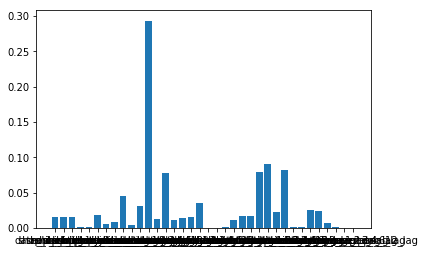

In [43]:
plt.bar(feature, GBRT.feature_importances_)

In [79]:
TOP10_feature = GBRT.feature_importances_
for i in range(36):
    max_index = np.argmax(TOP10_feature)
    print('TOP',i + 1,'feature:',feature[max_index])
    TOP10_feature[max_index] = -1

TOP 1 feature: item_id_cnt_month_mean_1_lag
TOP 2 feature: shop_turnover_2_lag
TOP 3 feature: shop_turnover_4_lag
TOP 4 feature: shop_turnover_1_lag
TOP 5 feature: item_id_cnt_month_mean_3_lag
TOP 6 feature: shop_id_cnt_month_mean_4_lag
TOP 7 feature: new_category_id_cnt_month_mean_1_lag
TOP 8 feature: shop_id_cnt_month_mean_12_lag
TOP 9 feature: item_turnover_per_1_lag
TOP 10 feature: item_turnover_per_2_lag
TOP 11 feature: shop_turnover_3_lag
TOP 12 feature: shop_id_cnt_month_mean_1_lag
TOP 13 feature: item_value
TOP 14 feature: new_category_id_cnt_month_mean_12_lag
TOP 15 feature: item_id
TOP 16 feature: new_category_id
TOP 17 feature: item_id_cnt_month_mean_12_lag
TOP 18 feature: date_block_num
TOP 19 feature: item_id_cnt_month_mean_6_lag
TOP 20 feature: item_id_cnt_month_mean_2_lag
TOP 21 feature: item_id_cnt_month_mean_4_lag
TOP 22 feature: new_category_id_cnt_month_mean_6_lag
TOP 23 feature: shop_id_cnt_month_mean_3_lag
TOP 24 feature: item_turnover_per_3_lag
TOP 25 feature: sho

In [95]:
y_[y_ > 20] = 20

In [96]:
sample_submission['item_cnt_month'] = y_

In [97]:
sample_submission.to_csv('./0812.csv', index=None)